In [182]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [183]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [184]:
tf.keras.backend.clear_session()

In [185]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [186]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [187]:
subject = 'Rondônia - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [188]:
data = pd.read_csv('2003_mo_model_input_RO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Rondônia - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego
0,2003-1,0.695011,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,0.636082,4.987,571416.488347,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,13.867,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.226062
1,2003-2,0.694993,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,0.636393,4.987,576005.312715,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,10.777,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.219943
2,2003-3,0.694975,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,0.636703,4.987,580594.137083,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,13.888,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.213823
3,2003-4,0.694957,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,0.637014,4.987,585182.961451,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,11.859,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.207703
4,2003-5,0.694939,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,0.637324,4.987,589771.785820,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,14.431,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.201584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


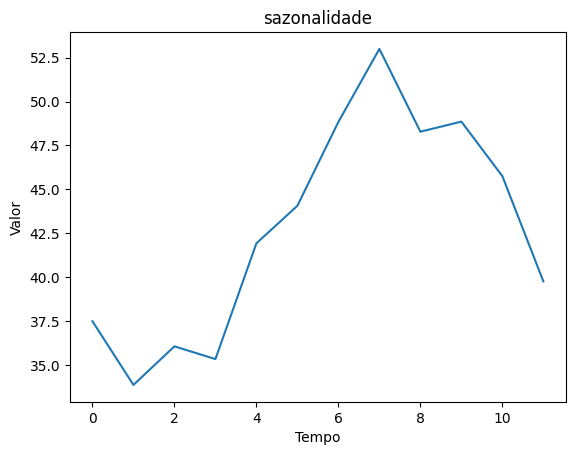

,sazonalidade
sazonalidade,
0,37.484568
1,33.856379
2,36.053154
3,35.327587
4,41.923759
5,44.063440
6,48.840487
7,52.998027
8,48.282743


In [189]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [190]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - IDH Educacao,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - IDH,Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade,Rondônia - Consumo de Cimento (t)
0,2003-1,0.695011,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,0.636082,4.987,571416.488347,0.688843,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.226062,37.484568,13.867
1,2003-2,0.694993,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,0.636393,4.987,576005.312715,0.689031,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.219943,33.856379,10.777
2,2003-3,0.694975,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,0.636703,4.987,580594.137083,0.689218,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.213823,36.053154,13.888
3,2003-4,0.694957,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,0.637014,4.987,585182.961451,0.689405,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.207703,35.327587,11.859
4,2003-5,0.694939,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,0.637324,4.987,589771.785820,0.689592,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.201584,41.923759,14.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.923759,NaN
245,2023-6,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.063440,NaN
246,2023-7,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.840487,NaN
247,2023-8,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.998027,NaN


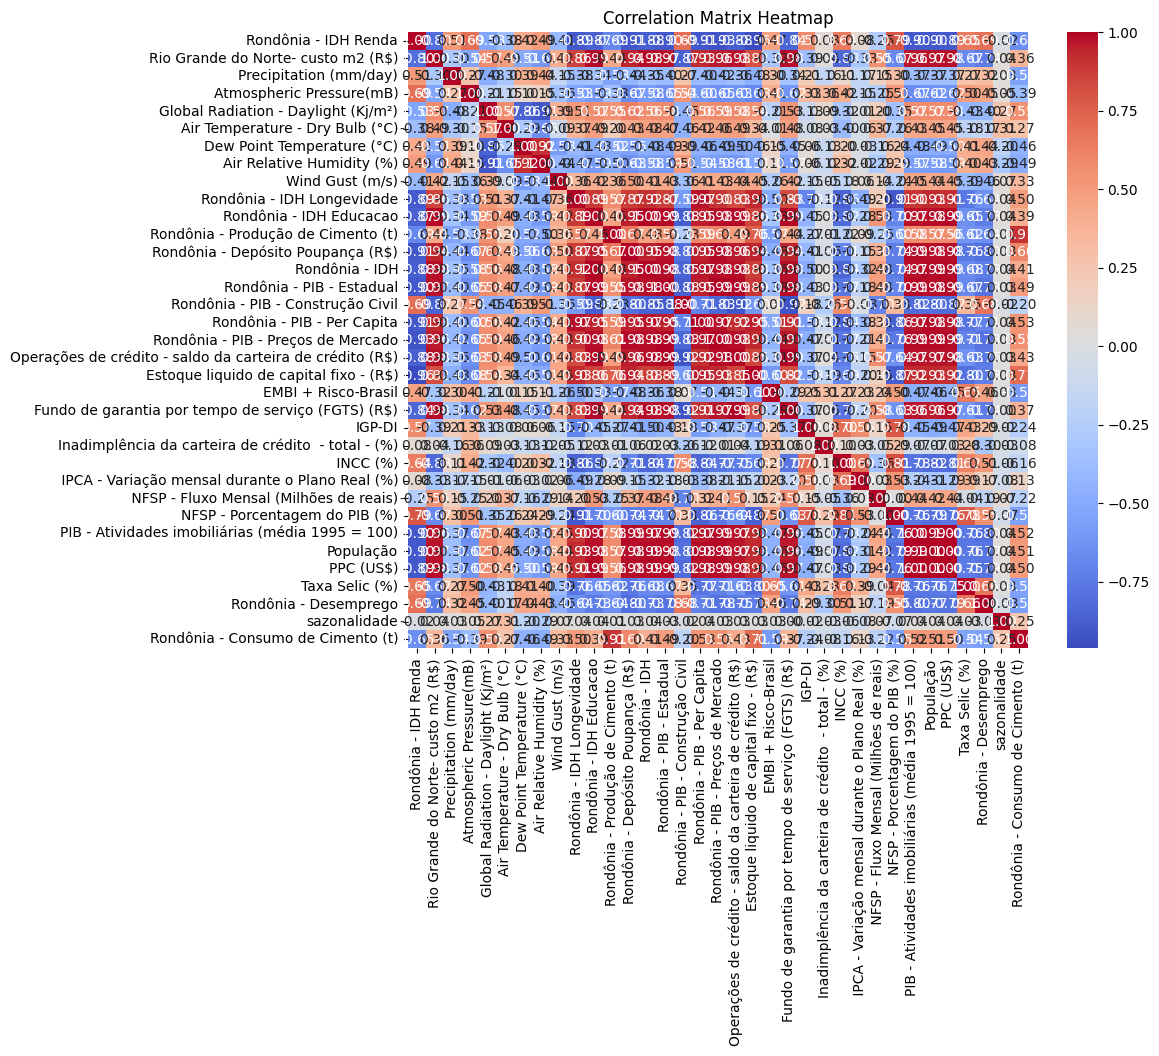

In [191]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [192]:
data =data.drop(['Rondônia - IDH Educacao',
                 'IGP-DI', 
                 'Rondônia - IDH',
                 'Inadimplência da carteira de crédito  - total - (%)',
                 ' INCC (%)',
                 'População',
                 'PIB - Atividades imobiliárias (média 1995 = 100)',
                 'Operações de crédito - saldo da carteira de crédito (R$)'], axis=1)
data

,Unnamed: 0,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade,Rondônia - Consumo de Cimento (t)
0,2003-1,0.695011,9944.060800,3.113133,1012.894825,1234.043145,25.915315,21.946910,80.535383,1.309704,0.738355,4.987,571416.488347,2.068350e+07,1.587672e+06,11.468162,1.828350e+07,7.330309e+06,231.510748,2.097001e+06,0.724032,-5331.049150,11.520143,169.247665,1.611498,8.226062,37.484568,13.867
1,2003-2,0.694993,10034.559262,3.111749,1012.827428,1234.314475,25.916210,21.946941,80.532819,1.310142,0.738649,4.987,576005.312715,2.071062e+07,1.589518e+06,11.472453,1.829323e+07,7.335910e+06,208.710157,2.000523e+06,0.690297,-5318.079644,11.189862,170.176810,1.450389,8.219943,33.856379,10.777
2,2003-3,0.694975,10120.152965,3.110942,1012.788113,1234.472751,25.916731,21.946959,80.531324,1.310398,0.738943,4.987,580594.137083,2.073774e+07,1.591364e+06,11.476744,1.830296e+07,7.341511e+06,227.704841,1.963278e+06,0.669681,-5436.417870,10.820792,171.135713,1.870184,8.213823,36.053154,13.888
3,2003-4,0.694957,10199.169751,3.110856,1012.783901,1234.489709,25.916787,21.946961,80.531164,1.310425,0.739237,4.987,585182.961451,2.076486e+07,1.593210e+06,11.481034,1.831268e+07,7.347112e+06,278.121073,1.954187e+06,0.660494,-5707.015274,10.417840,172.116904,1.355287,8.207703,35.327587,11.859
4,2003-5,0.694939,10272.393199,3.115569,1012.654620,1232.941105,25.920756,21.975240,80.629057,1.304969,0.739531,4.987,589771.785820,2.079198e+07,1.595056e+06,11.485325,1.832241e+07,7.352713e+06,344.827633,1.975493e+06,0.648337,-5599.317941,9.959690,173.072271,1.585538,8.201584,41.923759,14.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.923759,NaN
245,2023-6,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.063440,NaN
246,2023-7,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.840487,NaN
247,2023-8,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.998027,NaN


In [193]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade
0,2.082462,-1.568323,0.356349,1.574393,-0.105391,-0.455840,-0.457664,-0.223971,0.008517,-2.723698,-1.115226,-1.629995,-1.684237,0.358666,-2.401614,-1.935575,-2.389042,-0.582420,-1.347324,2.723741,0.364808,4.398348,-1.825286,2.132459,1.247042,-0.875038
1,2.052883,-1.546054,0.353303,1.567225,-0.103517,-0.454463,-0.457640,-0.224385,0.009909,-2.664359,-1.115226,-1.620962,-1.666360,0.383576,-2.358981,-1.906624,-2.352139,-0.799075,-1.380245,2.350880,0.368956,4.222509,-1.813648,1.592202,1.233793,-1.476164
2,2.023305,-1.524992,0.351526,1.563044,-0.102423,-0.453659,-0.457627,-0.224626,0.010721,-2.605021,-1.115226,-1.611928,-1.648484,0.408485,-2.316347,-1.877673,-2.315236,-0.618584,-1.392954,2.123016,0.331110,4.026019,-1.801637,2.999926,1.220544,-1.112198
3,1.993726,-1.505549,0.351335,1.562596,-0.102306,-0.453573,-0.457625,-0.224652,0.010808,-2.545682,-1.115226,-1.602895,-1.630607,0.433395,-2.273714,-1.848722,-2.278333,-0.139520,-1.396056,2.021477,0.244570,3.811492,-1.789347,1.273293,1.207295,-1.232411
4,1.964148,-1.487531,0.361711,1.548847,-0.113005,-0.447464,-0.435657,-0.208842,-0.006535,-2.486344,-1.115226,-1.593861,-1.612730,0.458305,-2.231081,-1.819771,-2.241431,0.494336,-1.388786,1.887113,0.279013,3.567576,-1.777381,2.045407,1.194046,-0.139545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.076887,1.829703,1.841752,0.213016,1.525704,1.371031,-1.120628,-1.518675,0.615733,0.716235,-0.247503,1.138929,1.167829,-1.179294,1.068920,1.031159,0.389193,-0.244459,1.237409,-2.010387,2.953658,-0.572934,1.413217,-1.311366,-1.264706,1.695261
188,0.086207,1.850481,1.546764,0.209454,1.054348,1.182558,-0.819099,-1.203706,0.632199,0.683445,-0.239967,1.134357,1.159325,-1.160375,1.051588,1.020921,0.370392,-0.199028,1.214214,-1.870713,3.351323,-0.588777,1.425045,-1.417143,-1.291394,0.914023
189,0.095526,1.872337,0.867088,0.234410,0.470777,0.752726,-0.476804,-0.748452,0.626943,0.650655,-0.218298,1.129785,1.150821,-1.141456,1.034256,1.010683,0.351592,-0.173807,1.409043,-1.806230,3.404908,-0.612606,1.436067,-1.597784,-1.318081,1.009077
190,0.104846,1.894705,0.956642,0.258962,0.140343,0.398022,-0.283936,-0.446641,0.323510,0.617866,-0.219108,1.125213,1.142317,-1.122538,1.016924,1.000446,0.332791,-0.169867,1.654237,-1.727496,3.671303,-0.640956,1.446142,-1.400787,-1.344769,0.494413


In [194]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      13.420
1      11.302
2      16.993
3      16.214
4      15.406
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Rondônia - Consumo de Cimento (t), Length: 249, dtype: float64

In [195]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade
0,2.082462,-1.568323,0.356349,1.574393,-0.105391,-0.455840,-0.457664,-0.223971,0.008517,-2.723698,-1.115226,-1.629995,-1.684237,0.358666,-2.401614,-1.935575,-2.389042,-0.582420,-1.347324,2.723741,0.364808,4.398348,-1.825286,2.132459,1.247042,-0.875038
1,2.052883,-1.546054,0.353303,1.567225,-0.103517,-0.454463,-0.457640,-0.224385,0.009909,-2.664359,-1.115226,-1.620962,-1.666360,0.383576,-2.358981,-1.906624,-2.352139,-0.799075,-1.380245,2.350880,0.368956,4.222509,-1.813648,1.592202,1.233793,-1.476164
2,2.023305,-1.524992,0.351526,1.563044,-0.102423,-0.453659,-0.457627,-0.224626,0.010721,-2.605021,-1.115226,-1.611928,-1.648484,0.408485,-2.316347,-1.877673,-2.315236,-0.618584,-1.392954,2.123016,0.331110,4.026019,-1.801637,2.999926,1.220544,-1.112198
3,1.993726,-1.505549,0.351335,1.562596,-0.102306,-0.453573,-0.457625,-0.224652,0.010808,-2.545682,-1.115226,-1.602895,-1.630607,0.433395,-2.273714,-1.848722,-2.278333,-0.139520,-1.396056,2.021477,0.244570,3.811492,-1.789347,1.273293,1.207295,-1.232411
4,1.964148,-1.487531,0.361711,1.548847,-0.113005,-0.447464,-0.435657,-0.208842,-0.006535,-2.486344,-1.115226,-1.593861,-1.612730,0.458305,-2.231081,-1.819771,-2.241431,0.494336,-1.388786,1.887113,0.279013,3.567576,-1.777381,2.045407,1.194046,-0.139545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-1.563175,1.087695,1.042859,-0.826837,0.594273,0.960143,0.403840,-0.064220,-0.056853,1.470484,-0.087019,0.814208,1.215933,-1.493457,1.031936,1.145432,0.819304,0.961603,1.338424,-0.214006,1.216560,-0.607704,1.044043,0.043807,-0.079052,-1.476164
158,-1.516391,1.112256,0.818609,-0.746263,0.513281,0.393282,0.203800,0.016266,-0.144623,1.450987,-0.105967,0.822780,1.221174,-1.488264,1.051337,1.152213,0.808136,1.030624,1.300351,-0.434717,1.155373,-0.620523,1.056960,0.210856,-0.144286,-1.112198
159,-1.469607,1.137089,-0.194875,-0.531241,0.864065,0.173099,-0.330188,-0.287487,-0.215700,1.431490,-0.124493,0.831353,1.226414,-1.483070,1.070737,1.158994,0.796969,1.039183,1.250508,-0.524091,1.056140,-0.631530,1.070172,0.107070,-0.209519,-1.232411
160,-1.422822,1.162595,-0.976113,-0.263219,0.930982,-0.001553,-0.808982,-0.565890,-0.278254,1.411993,-0.140092,0.839926,1.231655,-1.477877,1.090137,1.165775,0.785801,1.017171,1.240363,-0.614500,1.147619,-0.640320,1.083626,0.392942,-0.274753,-0.139545


In [196]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      13.420
1      11.302
2      16.993
3      16.214
4      15.406
        ...  
157    29.662
158    31.408
159    29.484
160    33.601
161    36.905
Name: Rondônia - Consumo de Cimento (t), Length: 162, dtype: float64

In [197]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [198]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 26)

In [199]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rondônia - IDH Renda,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rondônia - IDH Longevidade,Rondônia - Produção de Cimento (t),Rondônia - Depósito Poupança (R$),Rondônia - PIB - Estadual,Rondônia - PIB - Construção Civil,Rondônia - PIB - Per Capita,Rondônia - PIB - Preços de Mercado,Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PPC (US$),Taxa Selic (%),Rondônia - Desemprego,sazonalidade
126,-0.999423,0.421883,-0.561373,-1.240562,1.013048,-0.964194,-1.142362,-0.523663,4.033533,0.348276,1.079360,1.027193,0.768768,-0.731913,0.443163,0.775263,0.944085,-0.882533,0.551812,0.888984,-0.230612,-0.460555,0.697312,-1.048761,-1.186007,1.006432
127,-0.987018,0.440553,-0.369270,-2.243259,1.144423,-0.172977,-0.993427,-0.757347,3.254695,0.336955,1.020528,1.044293,0.788783,-0.758573,0.464268,0.791970,0.947319,-0.815413,0.566622,0.954254,-0.156322,-0.440372,0.706933,-0.649312,-1.119247,1.695261
128,-0.974612,0.459912,-0.432881,-3.145644,0.926971,0.216266,-0.549766,-0.575762,2.494720,0.325635,0.951051,1.061393,0.808798,-0.785233,0.485374,0.808677,0.950553,-0.745839,0.568617,1.045217,-0.120008,-0.419247,0.715675,-0.535369,-1.052486,0.914023
129,-0.962206,0.479025,-0.294886,-3.866085,0.685287,0.146555,-0.351809,-0.391348,1.768215,0.314315,0.901602,1.078492,0.828813,-0.811893,0.506479,0.825384,0.953786,-0.687348,0.719776,1.176395,-0.143194,-0.397019,0.723490,-1.288807,-0.985725,1.009077
130,-0.949801,0.503072,0.117897,-4.189024,0.393059,0.273612,-0.234544,-0.356598,1.165224,0.302995,0.847437,1.095592,0.848827,-0.838553,0.527585,0.842091,0.957020,-0.639220,0.905478,1.303259,-0.028712,-0.376532,0.730579,-1.507550,-0.918965,0.494413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.076887,1.829703,1.841752,0.213016,1.525704,1.371031,-1.120628,-1.518675,0.615733,0.716235,-0.247503,1.138929,1.167829,-1.179294,1.068920,1.031159,0.389193,-0.244459,1.237409,-2.010387,2.953658,-0.572934,1.413217,-1.311366,-1.264706,1.695261
188,0.086207,1.850481,1.546764,0.209454,1.054348,1.182558,-0.819099,-1.203706,0.632199,0.683445,-0.239967,1.134357,1.159325,-1.160375,1.051588,1.020921,0.370392,-0.199028,1.214214,-1.870713,3.351323,-0.588777,1.425045,-1.417143,-1.291394,0.914023
189,0.095526,1.872337,0.867088,0.234410,0.470777,0.752726,-0.476804,-0.748452,0.626943,0.650655,-0.218298,1.129785,1.150821,-1.141456,1.034256,1.010683,0.351592,-0.173807,1.409043,-1.806230,3.404908,-0.612606,1.436067,-1.597784,-1.318081,1.009077
190,0.104846,1.894705,0.956642,0.258962,0.140343,0.398022,-0.283936,-0.446641,0.323510,0.617866,-0.219108,1.125213,1.142317,-1.122538,1.016924,1.000446,0.332791,-0.169867,1.654237,-1.727496,3.671303,-0.640956,1.446142,-1.400787,-1.344769,0.494413


In [200]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 26)

In [201]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [202]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01),
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [203]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(30)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [204]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[688383032, 3034725508, 3531674310, 2231961512, 269898478, 4225740748, 2633193111, 1092763998, 1276818692, 1836106402, 1521049673, 549544689, 2054539740, 228253347, 1568074884, 2810844743, 588977794, 1362985079, 2683609056, 3909761019, 1482240424, 2740237720, 4259577309, 3296863423, 1649344203, 1037355456, 1045865037, 716523610, 1815028696, 1644617792]


Step: 0 ___________________________________________
val_loss: 173.16583251953125
winner_seed: 688383032


Step: 1 ___________________________________________
val_loss: 242.9849395751953


Step: 2 ___________________________________________
val_loss: 210.1136016845703


Step: 3 ___________________________________________
val_loss: 32.098079681396484
winner_seed: 2231961512


Step: 4 ___________________________________________
val_loss: 68.67323303222656


Step: 5 ___________________________________________
val_loss: 140.87124633789062


Step: 6 ___________________________________________
val_loss: 31.713218688964844
winner_seed: 2633193

In [211]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 155ms/step - loss: 3451.5720 - val_loss: 555.7495
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 1183.2866 - val_loss: 418.3626
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 677.8290 - val_loss: 312.7671
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 457.9950 - val_loss: 250.0214
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 355.0672 - val_loss: 656.0258
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 552.2016 - val_loss: 233.9742
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 330.1548 - val_loss: 302.9218
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 246.8545 - val_loss: 413.8397
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 223.0610 - val_loss: 197.5919
Epoch 10/10000
4/4 [==============================] - 0s 9ms/step - l

4/4 [==============================] - 0s 9ms/step - loss: 73.2094 - val_loss: 144.7725
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 70.9394 - val_loss: 175.4910
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 78.9848 - val_loss: 159.3656
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 68.7567 - val_loss: 176.3506
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 74.0306 - val_loss: 233.0366
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 68.9806 - val_loss: 141.9645
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 81.5896 - val_loss: 305.8445
Epoch 87/10000
4/4 [==============================] - 0s 9ms/step - loss: 73.6173 - val_loss: 152.2669
Epoch 88/10000
4/4 [==============================] - 0s 9ms/step - loss: 74.7383 - val_loss: 185.0618
Epoch 89/10000
4/4 [==============================] - 0s 9ms/step - loss: 67.1089 - val_

4/4 [==============================] - 0s 8ms/step - loss: 48.7515 - val_loss: 109.7605
Epoch 160/10000
4/4 [==============================] - 0s 8ms/step - loss: 49.6658 - val_loss: 132.0893
Epoch 161/10000
4/4 [==============================] - 0s 8ms/step - loss: 51.0712 - val_loss: 145.4930
Epoch 162/10000
4/4 [==============================] - 0s 8ms/step - loss: 48.8609 - val_loss: 160.9239
Epoch 163/10000
4/4 [==============================] - 0s 8ms/step - loss: 56.9740 - val_loss: 117.3789
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 49.9102 - val_loss: 145.6994
Epoch 165/10000
4/4 [==============================] - 0s 8ms/step - loss: 65.2322 - val_loss: 115.3213
Epoch 166/10000
4/4 [==============================] - 0s 8ms/step - loss: 62.2199 - val_loss: 131.4848
Epoch 167/10000
4/4 [==============================] - 0s 9ms/step - loss: 55.3257 - val_loss: 107.1561
Epoch 168/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.30

4/4 [==============================] - 0s 8ms/step - loss: 35.7107 - val_loss: 111.8849
Epoch 239/10000
4/4 [==============================] - 0s 9ms/step - loss: 36.6656 - val_loss: 97.2225
Epoch 240/10000
4/4 [==============================] - 0s 9ms/step - loss: 37.4277 - val_loss: 120.2445
Epoch 241/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.8801 - val_loss: 94.2371
Epoch 242/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.2611 - val_loss: 123.3553
Epoch 243/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.1789 - val_loss: 87.7889
Epoch 244/10000
4/4 [==============================] - 0s 9ms/step - loss: 35.4005 - val_loss: 62.0552
Epoch 245/10000
4/4 [==============================] - 0s 9ms/step - loss: 36.3269 - val_loss: 90.5978
Epoch 246/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.2114 - val_loss: 99.8342
Epoch 247/10000
4/4 [==============================] - 0s 8ms/step - loss: 36.1404 - v

4/4 [==============================] - 0s 8ms/step - loss: 27.2073 - val_loss: 91.5972
Epoch 318/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.5718 - val_loss: 81.7484
Epoch 319/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.0466 - val_loss: 80.6560
Epoch 320/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.5033 - val_loss: 79.7195
Epoch 321/10000
4/4 [==============================] - 0s 8ms/step - loss: 29.0686 - val_loss: 64.4947
Epoch 322/10000
4/4 [==============================] - 0s 9ms/step - loss: 28.0058 - val_loss: 88.1641
Epoch 323/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.2891 - val_loss: 90.2432
Epoch 324/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.7239 - val_loss: 72.8147
Epoch 325/10000
4/4 [==============================] - 0s 9ms/step - loss: 28.0325 - val_loss: 67.7195
Epoch 326/10000
4/4 [==============================] - 0s 9ms/step - loss: 29.0038 - val_

4/4 [==============================] - 0s 8ms/step - loss: 22.0391 - val_loss: 71.7346
Epoch 397/10000
4/4 [==============================] - 0s 9ms/step - loss: 21.9261 - val_loss: 60.2061
Epoch 398/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.1374 - val_loss: 87.9317
Epoch 399/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.1847 - val_loss: 57.9813
Epoch 400/10000
4/4 [==============================] - 0s 9ms/step - loss: 21.8634 - val_loss: 74.1780
Epoch 401/10000
4/4 [==============================] - 0s 8ms/step - loss: 22.3741 - val_loss: 79.8075
Epoch 402/10000
4/4 [==============================] - 0s 8ms/step - loss: 23.4357 - val_loss: 60.4339
Epoch 403/10000
4/4 [==============================] - 0s 8ms/step - loss: 20.7698 - val_loss: 86.4497
Epoch 404/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.4200 - val_loss: 53.0973
Epoch 405/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.3146 - val_

4/4 [==============================] - 0s 9ms/step - loss: 18.3788 - val_loss: 74.6458
Epoch 476/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.6658 - val_loss: 72.8324
Epoch 477/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.8491 - val_loss: 51.3332
Epoch 478/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.8980 - val_loss: 102.5970
Epoch 479/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.1796 - val_loss: 49.6996
Epoch 480/10000
4/4 [==============================] - 0s 9ms/step - loss: 19.5400 - val_loss: 52.5625
Epoch 481/10000
4/4 [==============================] - 0s 9ms/step - loss: 19.3350 - val_loss: 50.1704
Epoch 482/10000
4/4 [==============================] - 0s 9ms/step - loss: 19.7401 - val_loss: 57.4880
Epoch 483/10000
4/4 [==============================] - 0s 9ms/step - loss: 19.0414 - val_loss: 64.1404
Epoch 484/10000
4/4 [==============================] - 0s 9ms/step - loss: 19.3372 - val

4/4 [==============================] - 0s 8ms/step - loss: 15.7923 - val_loss: 46.5910
Epoch 555/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.5230 - val_loss: 61.4871
Epoch 556/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.6353 - val_loss: 61.6359
Epoch 557/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.9263 - val_loss: 46.0769
Epoch 558/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.3578 - val_loss: 59.9639
Epoch 559/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.5476 - val_loss: 48.9135
Epoch 560/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.6801 - val_loss: 71.7790
Epoch 561/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.6465 - val_loss: 65.7143
Epoch 562/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.8190 - val_loss: 72.9011
Epoch 563/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.5281 - val_

4/4 [==============================] - 0s 8ms/step - loss: 14.3934 - val_loss: 55.8963
Epoch 634/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.5251 - val_loss: 71.7273
Epoch 635/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.8332 - val_loss: 55.0043
Epoch 636/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.6831 - val_loss: 55.2789
Epoch 637/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.3966 - val_loss: 74.9704
Epoch 638/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.4182 - val_loss: 57.0698
Epoch 639/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.7245 - val_loss: 71.4457
Epoch 640/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.1173 - val_loss: 42.0496
Epoch 641/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.0620 - val_loss: 43.2732
Epoch 642/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.6865 - val_

4/4 [==============================] - 0s 9ms/step - loss: 12.9129 - val_loss: 50.0354
Epoch 713/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.9010 - val_loss: 47.5331
Epoch 714/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.9973 - val_loss: 54.0131
Epoch 715/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.0487 - val_loss: 63.5872
Epoch 716/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.7368 - val_loss: 51.8950
Epoch 717/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.9232 - val_loss: 45.1913
Epoch 718/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.5098 - val_loss: 41.3408
Epoch 719/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.2769 - val_loss: 36.0419
Epoch 720/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.8097 - val_loss: 60.5669
Epoch 721/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.1498 - val_

4/4 [==============================] - 0s 8ms/step - loss: 11.3671 - val_loss: 29.5205
Epoch 792/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.6542 - val_loss: 32.6691
Epoch 793/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.8932 - val_loss: 33.1775
Epoch 794/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.9811 - val_loss: 38.7146
Epoch 795/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.3275 - val_loss: 27.4311
Epoch 796/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.4286 - val_loss: 26.0806
Epoch 797/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.8148 - val_loss: 32.0579
Epoch 798/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.4553 - val_loss: 36.1509
Epoch 799/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.7703 - val_loss: 35.1811
Epoch 800/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.0384 - val_

Epoch 871/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.9057 - val_loss: 43.1641
Epoch 872/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.4373 - val_loss: 33.4982
Epoch 873/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.8557 - val_loss: 39.2913
Epoch 874/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.1786 - val_loss: 31.5391
Epoch 875/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.4813 - val_loss: 36.5041
Epoch 876/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.1878 - val_loss: 32.1856
Epoch 877/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.6980 - val_loss: 33.6348
Epoch 878/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.7151 - val_loss: 48.3263
Epoch 879/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.9940 - val_loss: 38.2852
Epoch 880/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.851

4/4 [==============================] - 0s 8ms/step - loss: 8.4144 - val_loss: 36.8698
Epoch 952/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.6449 - val_loss: 33.2087
Epoch 953/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.1096 - val_loss: 30.4080
Epoch 954/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.9831 - val_loss: 34.4373
Epoch 955/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.3924 - val_loss: 33.9590
Epoch 956/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.4412 - val_loss: 33.6956
Epoch 957/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.5299 - val_loss: 36.0492
Epoch 958/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.2951 - val_loss: 27.2889
Epoch 959/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.1025 - val_loss: 30.5199
Epoch 960/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3121 - val_loss: 35.0

4/4 [==============================] - 0s 10ms/step - loss: 16.5841 - val_loss: 167.5722
Epoch 1030/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.4205 - val_loss: 155.8081
Epoch 1031/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.9359 - val_loss: 146.6492
Epoch 1032/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.6356 - val_loss: 171.5569
Epoch 1033/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.7790 - val_loss: 171.3954
Epoch 1034/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.6608 - val_loss: 160.1565
Epoch 1035/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.7323 - val_loss: 157.3616
Epoch 1036/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.5638 - val_loss: 158.7556
Epoch 1037/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.4633 - val_loss: 134.8800
Epoch 1038/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 12ms/step - loss: 9.1696 - val_loss: 126.6462
Epoch 1107/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.8765 - val_loss: 107.6157
Epoch 1108/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.2984 - val_loss: 99.2137
Epoch 1109/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.7655 - val_loss: 76.8730
Epoch 1110/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.4886 - val_loss: 108.4396
Epoch 1111/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.4958 - val_loss: 82.1203
Epoch 1112/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.7220 - val_loss: 106.3720
Epoch 1113/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.5264 - val_loss: 102.0572
Epoch 1114/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.8130 - val_loss: 110.1578
Epoch 1115/10000
4/4 [==============================] - 0s 12ms/step - loss

4/4 [==============================] - 0s 10ms/step - loss: 6.9865 - val_loss: 116.6737
Epoch 1185/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.5488 - val_loss: 104.1964
Epoch 1186/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1939 - val_loss: 125.7477
Epoch 1187/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6871 - val_loss: 112.8161
Epoch 1188/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.6951 - val_loss: 88.3681
Epoch 1189/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.0689 - val_loss: 105.6273
Epoch 1190/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.0449 - val_loss: 106.0449
Epoch 1191/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.9771 - val_loss: 90.2538
Epoch 1192/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.5041 - val_loss: 92.4527
Epoch 1193/10000
4/4 [==============================] - 0s 12ms/step - loss

In [212]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [213]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,35.733624,38.79805,40.450459,40.696796,39.964123,38.32877,36.042961,34.000454,32.728275,32.489159,34.382435,39.116364,42.695507,44.065403,44.324928,43.94698,42.92564,40.758331,38.042679,36.542149,36.459011,38.022865,41.811661,46.399826,48.178127,48.641197,48.348907,47.682652,45.831032,41.26321
Target,36.094,42.556,41.193,37.053,33.527,25.616,25.221,23.321,23.927,24.561,20.135,34.837,34.338,39.293,41.61,43.544,35.658,29.693,32.559,24.91,28.713,32.66,31.635,35.142,36.419,40.3,35.493,38.489,35.591,27.53
Error,0.360378,3.75795,0.742542,3.643795,6.437122,12.71277,10.82196,10.679455,8.801275,7.928158,14.247435,4.279362,8.357506,4.772404,2.714928,0.402981,7.267639,11.065331,5.483681,11.632149,7.746012,5.362865,10.176661,11.257828,11.759129,8.341198,12.855907,9.193653,10.240032,13.73321


In [214]:
display(mae)
display(mape)

7.892511

0.2651916

In [215]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [216]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[442.73148]] - Target[368.041]| =  Error: [[74.69049]]; MAPE:[[0.20294069]]
1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[495.995]] - Target[409.75500000000005]| =  Error: [[86.23999]]; MAPE:[[0.2104672]]
1/1 [==============================] - 0s 14ms/step
Ano-5: |Prediction[[279.94513]] - Target[213.822]| =  Error: [[66.12312]]; MAPE:[[0.30924377]]


[array([[74.69049]], dtype=float32),
 array([[86.23999]], dtype=float32),
 array([[66.12312]], dtype=float32)]

75.68453

0.24088389